# TensorFlow text classification example

Use a pretrained model to classify IMDB movie reviews into _negative_ and _positive_.

From https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub. It's basically the same code as in that page, copied over so I force myself to inspect and run each section on my own, to understand them better,

## Load modules

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

W0417 14:13:58.902724 4642297280 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


## Load data

Download the dataset and load it into Pandas dataframes, one for training and one for testing.

In [2]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()

In [3]:
print('{} samples'.format(train_df.size))
print('\nSome of them:')
train_df.head()

75000 samples

Some of them:


,sentence,sentiment,polarity
0,"Once in a while, a film comes along that raise...",10,1
1,American boy Jesse took the train to Vienna in...,9,1
2,"Delirious, near plot-less mood piece and if it...",8,1
3,"Herbet Clutter, wife Bonnie, and their teenage...",8,1
4,"If you want to remember MJ, this is a good pla...",10,1


## Create and train a model

### Input functions

Read data from the Pandas dataframes.

In [4]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

## Feature columns

Here we encounter our first TensorFlow Hub module.

In this text classification example we don't work with the text directly. We work instead with a numeric representation of the text, the [_text (or word) embedding_](https://en.wikipedia.org/wiki/Word_embedding) of that text.

This module creates the text embedding: parse the sentences, create the embedding. The embedding is then used by the classifier.

In [5]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

### Estimator

The estimator is a neural network with two fully connected layers.

In [6]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

### Training

In [10]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=1000);

### Evaluation

In [11]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

Training set accuracy: 0.8076000213623047
Test set accuracy: 0.7964800000190735


### Confusion matrix

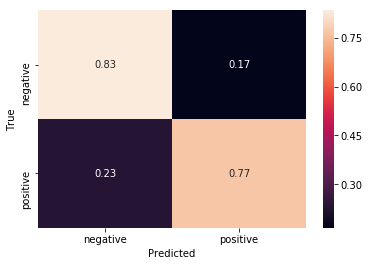

In [9]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(train_df["polarity"], 
                           get_predictions(estimator, predict_train_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

## Appendix

### Display word embedding

Self-contained code to show how the module for word embedding (https://tfhub.dev/google/nnlm-en-dim128/1) works.

From https://www.kaggle.com/rtatman/notebook-with-tensorflow-hub.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

with tf.Graph().as_default():
  module_url = "https://tfhub.dev/google/nnlm-en-dim128/1"
  embed = hub.Module(module_url)
  embeddings = embed(["A long sentence.", "single-word",
                      "http://example.com"])

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())

    print(sess.run(embeddings)[:,:5])